# Sketch to Shoes Images Using Conditional Latend Diffusion Models (CLDMs)

### Imports

In [1]:
import zipfile, glob, os, json, torch, torchvision.transforms as T, itertools

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from typing import Callable, Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'torchvision'

# Kaggle Download: Edges2Shoes (Colab)
This section installs Kaggle, configures credentials (env vars or file upload), and downloads the `balraj98/edges2shoes-dataset` train split for creating a PyTorch DataLoader.

### Set Kaggle Credentials for Dataset Download

In [ ]:
# KAGGLE_USERNAME = "your_username"
# KAGGLE_KEY = "your_api_key"

# # Export to environment so Kaggle CLI/Python API can use them directly
# os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
# os.environ['KAGGLE_KEY'] = KAGGLE_KEY

# # Also write kaggle.json for compatibility
# kaggle_dir = Path.home() / '.kaggle'
# kaggle_dir.mkdir(exist_ok=True)
# creds_path = kaggle_dir / 'kaggle.json'
# with open(creds_path, 'w') as f:
#     json.dump({'username': KAGGLE_USERNAME, 'key': KAGGLE_KEY}, f)
# os.chmod(creds_path, 0o600)

# print(f"Kaggle credentials set (username={KAGGLE_USERNAME})")

Kaggle credentials set (username=your_username, key=your****)


### Download Dataset

In [3]:
# Download and extract the dataset
DATA_ROOT = Path('/content/data')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

DATASET_SLUG = 'balraj98/edges2shoes-dataset'
ZIP_PATH = DATA_ROOT / 'edges2shoes.zip'

!kaggle datasets download -d {DATASET_SLUG} -p {DATA_ROOT} -o

# Find the downloaded zip file (name can vary)
zips = sorted(DATA_ROOT.glob('*.zip'))
if not zips:
    raise FileNotFoundError('No zip files downloaded from Kaggle')

# Use the first zip found (or the only one)
zip_file = zips[0]
print('Found zip:', zip_file)

# Extract
extract_dir = DATA_ROOT / 'edges2shoes'
extract_dir.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zf:
    zf.extractall(extract_dir)

print('Extracted to', extract_dir)

def find_train_dir(base: Path) -> Path:
    # Search for a 'train' directory with image files inside
    candidate_train_dirs = []
    for p in base.rglob('train'):
        if p.is_dir():
            # Check for images
            imgs = list(p.glob('*.jpg')) + list(p.glob('*.jpeg')) + list(p.glob('*.png'))
            if len(imgs) > 0:
                candidate_train_dirs.append((p, len(imgs)))
    if not candidate_train_dirs:
        raise FileNotFoundError("Couldn't locate a 'train' directory with images under " + str(base))
    # Pick the one with most images
    candidate_train_dirs.sort(key=lambda x: x[1], reverse=True)
    return candidate_train_dirs[0][0]

TRAIN_DIR = find_train_dir(extract_dir)
print('Train images dir:', TRAIN_DIR)
train_count = len(list(TRAIN_DIR.glob('*.jpg'))) + len(list(TRAIN_DIR.glob('*.jpeg'))) + len(list(TRAIN_DIR.glob('*.png')))
print('Train image count:', train_count)

Dataset URL: https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset
License(s): other
  0% 0.00/2.04G [00:00<?, ?B/s]Downloading edges2shoes-dataset.zip to /content/data
 98% 2.00G/2.04G [00:25<00:00, 51.1MB/s]
100% 2.04G/2.04G [00:25<00:00, 85.9MB/s]

100% 2.04G/2.04G [00:25<00:00, 85.9MB/s]
Found zip: /content/data/edges2shoes-dataset.zip
Found zip: /content/data/edges2shoes-dataset.zip
Extracted to /content/data/edges2shoes
Extracted to /content/data/edges2shoes
Train images dir: /content/data/edges2shoes/train
Train images dir: /content/data/edges2shoes/train
Train image count: 49825
Train image count: 49825


### Data Loader
Implements a PyTorch `Dataset` that splits each 512x256 paired image into `(sketch, real)` halves of size 256x256.

In [4]:
class Edges2ShoesPairs(Dataset):
    def __init__(
        self,
        root_dir: str | os.PathLike,
        sketch_first: bool = True,
        transform: Optional[Callable[[Image.Image], torch.Tensor]] = None,
        file_extensions: Tuple[str, ...] = ('.jpg', '.jpeg', '.png'),
    ) -> None:
        self.root_dir = os.fspath(root_dir)
        self.sketch_first = sketch_first
        self.transform = transform
        self.files: List[str] = []
        for ext in file_extensions:
            self.files.extend(sorted([
                os.path.join(self.root_dir, f)
                for f in os.listdir(self.root_dir)
                if f.lower().endswith(ext)
            ]))
        if not self.files:
            raise FileNotFoundError(f'No images found in {self.root_dir}')

        # Default transform: to tensor in [-1, 1]
        if self.transform is None:
            self.transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])

    def __len__(self) -> int:
        return len(self.files)

    def _split_pair(self, img: Image.Image) -> Tuple[Image.Image, Image.Image]:
        # Ensure correct orientation (width should be 512, height 256)
        w, h = img.size
        if w != 512 or h != 256:
            img = img.resize((512, 256), Image.BICUBIC)
            w, h = img.size
        mid = w // 2
        left = img.crop((0, 0, mid, h))
        right = img.crop((mid, 0, w, h))
        if self.sketch_first:
            sketch, real = left, right
        else:
            sketch, real = right, left
        # Final safety: ensure 256x256
        if sketch.size != (256, 256):
            sketch = sketch.resize((256, 256), Image.BICUBIC)
        if real.size != (256, 256):
            real = real.resize((256, 256), Image.BICUBIC)
        return sketch, real

    def __getitem__(self, idx: int):
        path = self.files[idx]
        with Image.open(path) as im:
            im = im.convert('RGB')
            sketch_img, real_img = self._split_pair(im)
        sketch = self.transform(sketch_img) if self.transform else sketch_img
        real = self.transform(real_img) if self.transform else real_img
        return {
            'sketch': sketch,
            'image': real,
            'path': path,
        }

# Instantiate dataset and dataloader
BATCH_SIZE = 16
NUM_WORKERS = 2  # Colab-friendly; increase if needed

train_dataset = Edges2ShoesPairs(root_dir=str(TRAIN_DIR), sketch_first=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

len(train_dataset), BATCH_SIZE


(49825, 16)

In [5]:
# Quick sanity check: iterate one batch and show shapes
batch = next(iter(train_loader))
print('Batch keys:', list(batch.keys()))
print('Sketch tensor:', batch['sketch'].shape, batch['sketch'].dtype, batch['sketch'].min().item(), batch['sketch'].max().item())
print('Image tensor:', batch['image'].shape, batch['image'].dtype, batch['image'].min().item(), batch['image'].max().item())

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch keys: ['sketch', 'image', 'path']
Sketch tensor: torch.Size([16, 3, 256, 256]) torch.float32 -1.0 1.0
Image tensor: torch.Size([16, 3, 256, 256]) torch.float32 -1.0 1.0


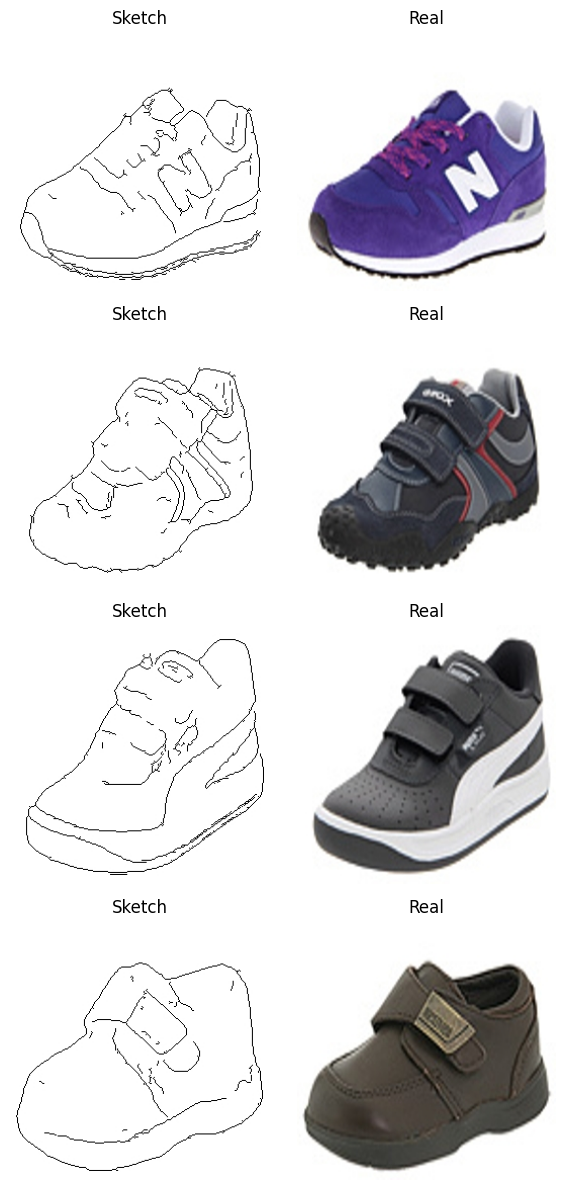

In [ ]:
# Optional: visualize a few pairs

def denorm(x):
    # x in [-1,1] -> [0,1]
    return (x * 0.5 + 0.5).clamp(0, 1)

def show_pairs(batch, n=4):
    s = denorm(batch['sketch'][:n]).cpu().numpy()
    r = denorm(batch['image'][:n]).cpu().numpy()
    # Convert CHW->HWC
    s = np.transpose(s, (0, 2, 3, 1))
    r = np.transpose(r, (0, 2, 3, 1))
    cols = 2
    rows = n
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        plt.subplot(rows, cols, 2*i+1)
        plt.imshow(s[i])
        plt.axis('off')
        plt.title('Sketch')
        plt.subplot(rows, cols, 2*i+2)
        plt.imshow(r[i])
        plt.axis('off')
        plt.title('Real')
    plt.tight_layout()
    plt.show()

show_pairs(batch, n=1)

### Sample Image : Original, Latent Space, Reconstruction

In [10]:
# use pre trained VAE model to take 4 sample real images and reconstruct them


### Downsampling of Sketch

In [11]:
# take 256 by 256 sketch, apply max pooling and then use as input to diffusion model to generate image

# Alternative Approach
# apply a probabilistic pooling approach: pixels for us are either black or white
# if 3 out of 4 pixels are black, then the pooled pixel is black with probability 0.75 and white with probability 0.25
# if 1 out of 4 pixels are black, then the pooled pixel is black with probability 0.25 and white with probability 0.75

### Training Conditional U-net with Pre-Trained KL-VAE

In [12]:
# train the U-net diffusion model on the sketch to image task (kl-f8)

### Training Conditional U-net with Pre-Trained VQ-VAE

In [13]:
### Training Conditional U-net with Pre-Trained VQ-VAE (vq-f4)

### Train KL-VAE from Scratch for Real Shoe Images

In [14]:
# train a VAE from scratch to represent real images as latent vectors

### Training Conditional U-Net with Custom KL-VAE

In [15]:
# train conditional U-net with Pre-Trained KL-VAE